In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

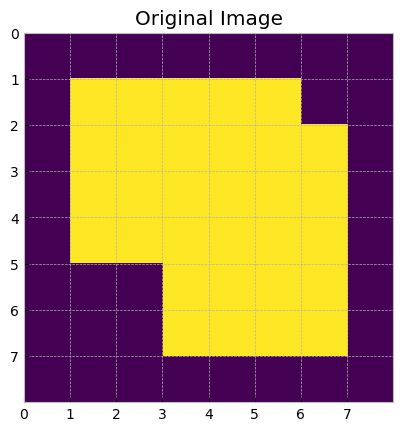

In [2]:
# A 8x8 binary image represented as a numpy array
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Original Image')

In [3]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

In [4]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

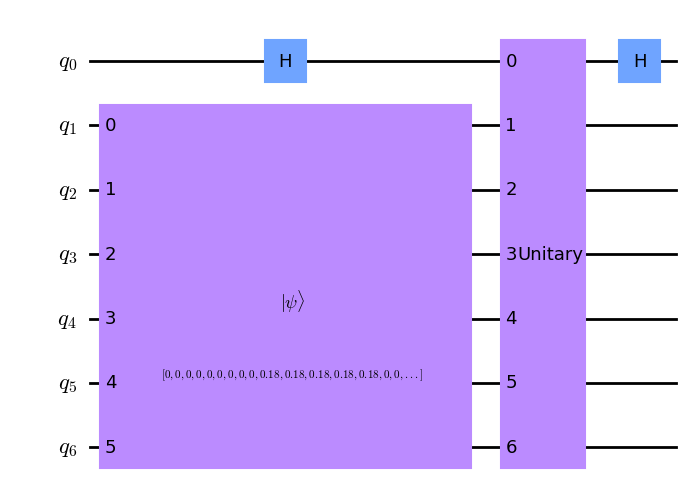

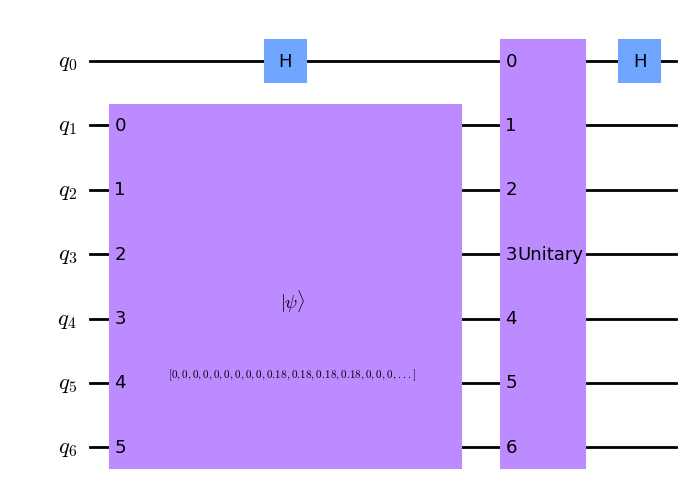

In [5]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [7]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h,max_size = 128))
print()
print('Vertical scan statevector:')
display(array_to_latex(sv_v,max_size = 128))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

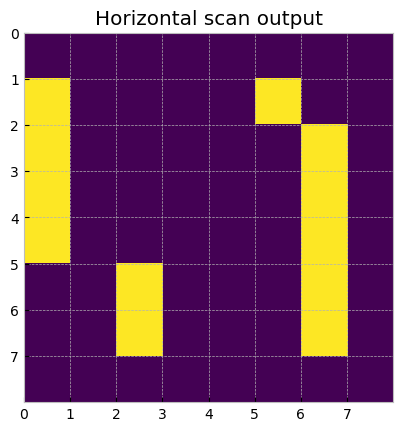

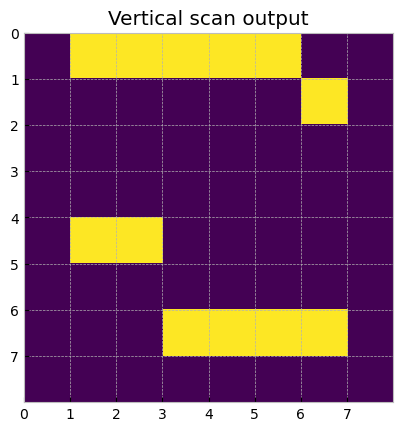

In [8]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

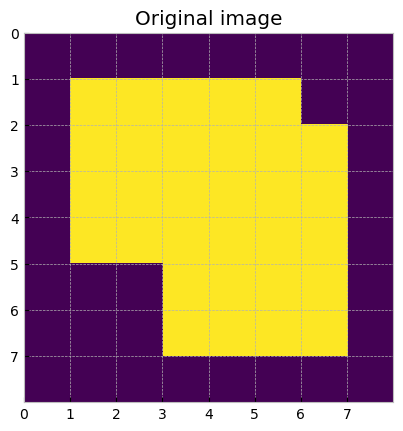

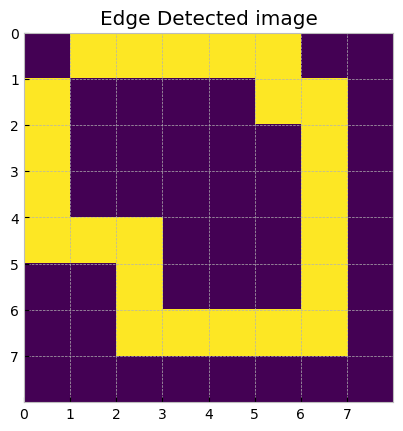

In [9]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')